In [1]:
import torch

from torch.nn import Module, Embedding, Linear, ModuleList
from einops import rearrange, reduce, repeat
from utils.components import TransformerBlock, ConditionalLayerNorm, GatedFFN, Attention

from dataclasses import dataclass
from typing import Optional, Tuple, Union

from utils.multimodal import ModalMTM, ModalTailMTM, ModalFuncMTM
from utils.loss_fn import f_kernel_crps

from torch import autocast

import matplotlib.pyplot as plt
import numpy as np

Einsum equation: b,t,v,hw->btvhw
Joint shape: torch.Size([2048, 6, 5, 16, 30])
Sampled mask shape: torch.Size([2048, 512])


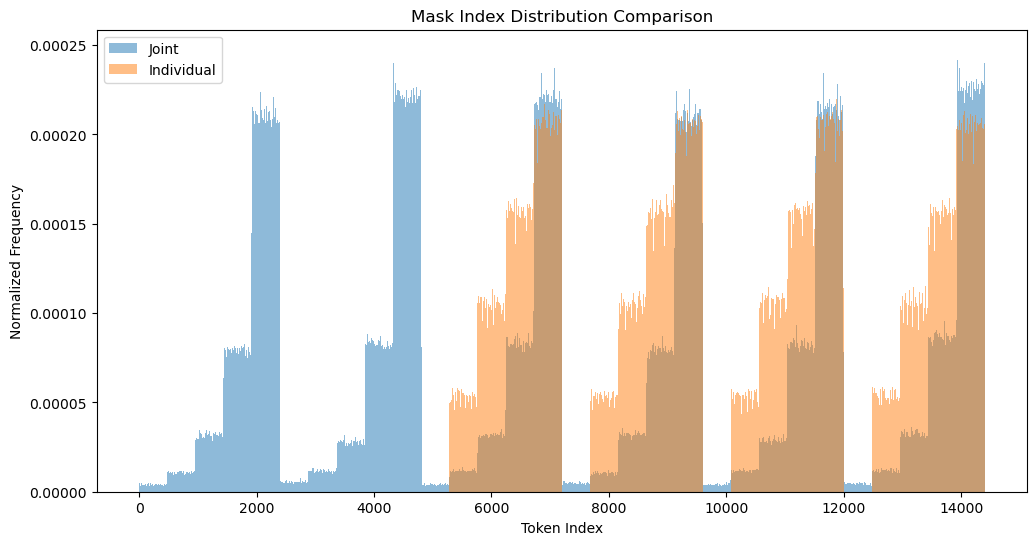

In [6]:
import torch
import matplotlib.pyplot as plt
from einops import repeat

# Config
H, W = 16, 30
B, T, V, S = 2048, 6, 5, H * W  # batch, time, variables, space
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = torch.Generator(device=device).manual_seed(42)

world_cfg = {
    "num_tokens": 1024,
    "alpha": 5.0,
}

# Layout of flatland tokens
flatland_token_layout = ['t', 'v', 'h', 'w']

# Token sizes
token_sizes = {
    't': T,
    'v': V,
    'h': H,
    'w': W
}

def default_priors():
    return {
        'b': lambda _: torch.ones(B, device= device),
        't': lambda _: torch.ones(T, device= device),
        "v": lambda _: torch.ones(V, device= device),
        "hw":  lambda _: torch.ones((token_sizes["h"], token_sizes["w"]), device=device),
    }

def masking_priors_fn():
    return {
        "bt": lambda _: sample_dirichlet((B, token_sizes['t']), sharpness=3., weights= torch.arange(T, device=device)),
        "bv": lambda _: sample_dirichlet((B, token_sizes['v']), sharpness=3.),
    }

def forecasting_priors_fn():
    return {
        't': lambda _: torch.as_tensor([0, 0, 1, 1, 1, 1], device= device),
        "v": lambda _: per_variable_weights,
    }

per_variable_weights = torch.arange(V, device=device).float()

def sample_dirichlet(shape, weights=1.0, sharpness=1.0):
    w = torch.ones(shape, device=device) * torch.as_tensor(weights, device=device)
    alpha = w.softmax(-1) * sharpness
    return torch._sample_dirichlet(alpha, generator=generator)

def sample_masking_rates(rate_cfg):
    N = world_cfg["num_tokens"]
    rate = torch.empty((1,), device=device)
    if rate_cfg["std"] > 0:
        rate = torch.nn.init.trunc_normal_(rate, **rate_cfg, generator=generator)
    else:
        rate.fill_(rate_cfg["mean"])
    return int(N * rate.item())

def sample_mask(priors, rate):
    layout = flatland_token_layout
    layout_axes = set(layout) | {"b"}

    defaults = default_priors()
    defaults.update(priors)

    keys, tensors = [], []
    for key, fn in defaults.items():
        if set(key).issubset(layout_axes):
            keys.append(key)
            tensors.append(fn(None))  # no `self` needed

    lhs = ",".join(keys)
    rhs = "b" + "".join(layout) if "b" in "".join(keys) else "".join(layout)
    einsum_eq = f"{lhs}->{rhs}"

    joint = torch.einsum(einsum_eq, *tensors)
    mask = torch.multinomial(joint.flatten(1), rate, replacement=False)
    
    # Debug output
    print(f"Einsum equation: {einsum_eq}")
    print(f"Joint shape: {joint.shape}")
    print(f"Sampled mask shape: {mask.shape}")
    return mask

def sample_joint_masks(rate):
    time_prior = sample_dirichlet((B, T), sharpness=world_cfg["alpha"])
    variable_prior = sample_dirichlet((B, V), weights=per_variable_weights)
    space_prior = torch.ones((H, W), device =device)
    joint = torch.einsum('b t, b v, h w -> b t v h w', time_prior, variable_prior, space_prior)
    joint = rearrange(joint, f"b t v h w -> b (t v h w)")
    src_mask = torch.multinomial(joint, rate, replacement=False, generator=generator)
    return src_mask

def sample_individual_masks():
    prior = sample_dirichlet((B, T), sharpness=world_cfg["alpha"])
    prior = repeat(prior, 'b t -> b (t s)', s=S)
    
    masks = []
    for v in range(V):
        rate = sample_masking_rates({"mean": per_variable_weights[v], "std": 0.0, 'a': 0.05, 'b': 0.2})
        idx = torch.multinomial(prior, num_samples=rate, replacement=False, generator=generator)
        full_idx = (idx // S) * V * S + v * S + (idx % S)
        masks.append(full_idx)
    
    src_mask = torch.cat(masks, dim=-1)
    return src_mask

# Run both samplers
rate = sample_masking_rates({"mean": 0.5, "std": 0., 'a': 0.05, 'b': 1.})

joint_src = sample_joint_masks(rate)
indiv_src = sample_mask(forecasting_priors_fn(), rate)
#indiv_src, _ = sample_individual_masks()

# Compare: histogram of flat index distributions
def plot_mask_hist(mask_tensor, label):
    flat = mask_tensor.flatten().cpu().numpy()
    plt.hist(flat, bins=world_cfg["num_tokens"], alpha=0.5, label=label, density=True)

plt.figure(figsize=(12, 6))
plot_mask_hist(joint_src, "Joint")
plot_mask_hist(indiv_src, "Individual")
plt.legend()
plt.title("Mask Index Distribution Comparison")
plt.xlabel("Token Index")
plt.ylabel("Normalized Frequency")
plt.show()

In [ ]:
T, V = 8, 8
B = 1000
S = 256
shape = (B, T)
sharpness = 3
R = 1024

In [ ]:
w = torch.ones(shape).view(B, -1)
alpha = w.softmax(-1) * sharpness
prior = torch._sample_dirichlet(alpha).repeat_interleave(V, -1)
prior = prior.view(B, T, V).sort(1).values.view(B, -1)
prior = prior.mean(dim = 0).clamp(1e-6, 1 - 1e-6).softmax(0)

In [503]:
prior * T * V

tensor([0.8922, 0.8922, 0.8922, 0.8922, 0.8922, 0.8922, 0.8922, 0.8922, 0.9083,
        0.9083, 0.9083, 0.9083, 0.9083, 0.9083, 0.9083, 0.9083, 0.9273, 0.9273,
        0.9273, 0.9273, 0.9273, 0.9273, 0.9273, 0.9273, 0.9508, 0.9508, 0.9508,
        0.9508, 0.9508, 0.9508, 0.9508, 0.9508, 0.9799, 0.9799, 0.9799, 0.9799,
        0.9799, 0.9799, 0.9799, 0.9799, 1.0218, 1.0218, 1.0218, 1.0218, 1.0218,
        1.0218, 1.0218, 1.0218, 1.0891, 1.0891, 1.0891, 1.0891, 1.0891, 1.0891,
        1.0891, 1.0891, 1.2306, 1.2306, 1.2306, 1.2306, 1.2306, 1.2306, 1.2306,
        1.2306])

Text(0, 0.5, 'T')

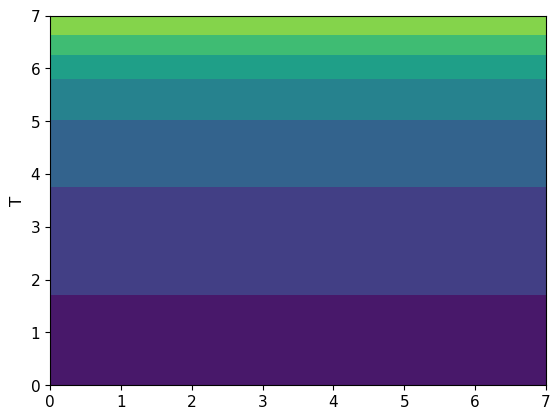

In [497]:
plt.contourf(prior.view(T, V))
plt.ylabel('T')

In [ ]:
alphas = np.logspace(-3, 3, num=24)
cdf_t = torch.zeros((len(alphas), T))
cdf_v = torch.zeros((len(alphas), V))
probs = []
for i, sharpness in enumerate(alphas):
    w = torch.ones(shape).view(B, -1)
    alpha = w / w.sum(-1, keepdim= True)  # normalize to probability simplex
    alpha = alpha * sharpness * w.size(-1)
    dirichlet_src = torch._sample_dirichlet(alpha).sort(dim = -1, descending=True).values

    probs.append(dirichlet_src.mean(dim = 0).clamp(1e-6, 1 - 1e-6))
    dirichlet_src = dirichlet_src.repeat_interleave(S, dim=-1)
    src = torch.multinomial(dirichlet_src, R, replacement=False)
    t_src = (src // S) // V
    v_src = (src // S) % V
    t_counts = torch.stack([torch.bincount(m, minlength=T) for m in t_src]).float() / R
    v_counts = torch.stack([torch.bincount(m, minlength=V) for m in v_src]).float() / R
    cdf_t[i ] = t_counts.mean(dim = 0).clamp(1e-6, 1 - 1e-6)    
    cdf_v[i] = v_counts.mean(dim = 0).clamp(1e-6, 1 - 1e-6)   


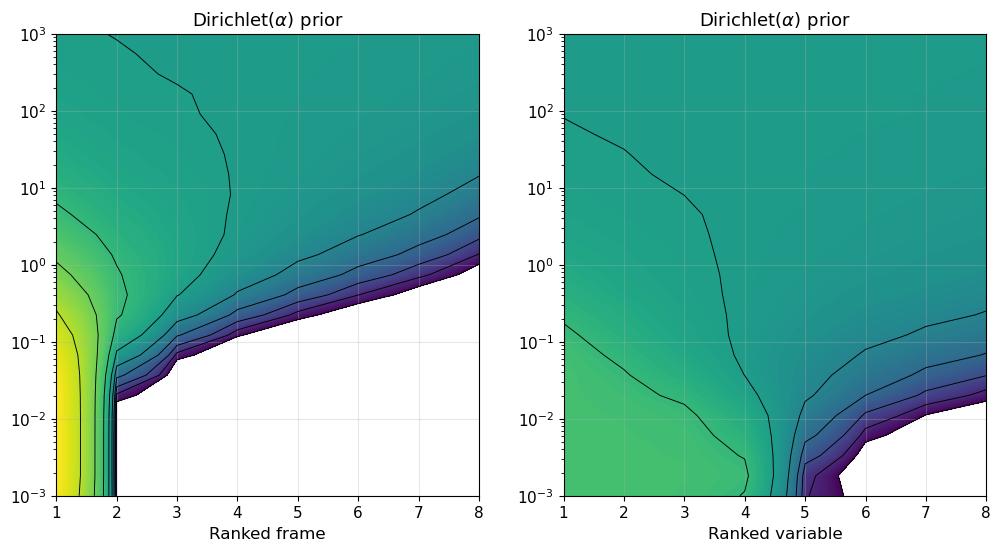

In [367]:
plt.rc("font", size=11)          # the default text size
plt.rc("axes", titlesize=13)     # subplot titles
plt.rc("axes", labelsize=12)     # x/y labels
plt.rc("xtick", labelsize=11)
plt.rc("ytick", labelsize=11)
plt.rc("legend", fontsize=9)

from matplotlib.ticker import LogLocator
from matplotlib.colors import LogNorm

# --- 1) Make your grid of x (ranks) and y (alpha) values:
x = np.arange(T)             # ranks 0,1,…,T-1
y = alphas                   # log‐spaced α’s, e.g. np.logspace(-3, 1, num=len(alphas))
X, Y = np.meshgrid(x, y)


eps = 1e-6
levels = 10**np.linspace(-2, 0., 100)
sparse_levels = 10**np.linspace(-2, 0., 10)
vmin = levels[0]
vmax = levels[-1]

fig, ax = plt.subplots(1,2, figsize= (12, 6))
# Plot for cdf[0]
cf0 = ax[0].contourf(
    X, Y, cdf_t,
    levels=levels,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap="viridis",
)

ax[0].grid(True, alpha=0.3)

cs0 = ax[0].contour(
    X, Y, cdf_t,
    levels=sparse_levels,
    colors='black',
    linewidths=0.65
)
ax[0].set_yscale('log')
ax[0].set_xlabel("Ranked frame")
ax[0].set_title(r"Dirichlet$(\alpha)$ prior")
ax[0].set_xticks(np.arange(0, T, 1))
ax[0].set_xticklabels(np.arange(1, T + 1, 1))


# --- 1) Make your grid of x (ranks) and y (alpha) values:
x = np.arange(V)             # ranks 0,1,…,T-1
y = alphas                   # log‐spaced α’s, e.g. np.logspace(-3, 1, num=len(alphas))
X, Y = np.meshgrid(x, y)
cf0 = ax[1].contourf(
    X, Y, cdf_v,
    levels=levels,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap="viridis",
)

ax[1].grid(True, alpha=0.3)

cs0 = ax[1].contour(
    X, Y, cdf_v,
    levels=sparse_levels,
    colors='black',
    linewidths=0.65
)
ax[1].set_yscale('log')
ax[1].set_xlabel("Ranked variable")
ax[1].set_title(r"Dirichlet$(\alpha)$ prior")
ax[1].set_xticks(np.arange(0, V, 1))
ax[1].set_xticklabels(np.arange(1, V + 1, 1))
plt.show()

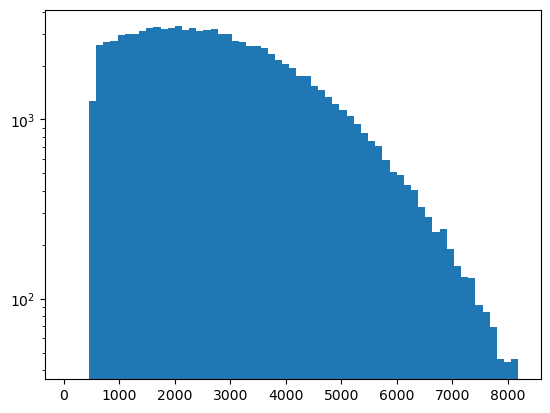

In [163]:
r = torch.empty(100000)
r = torch.nn.init.trunc_normal_(r, 0.25, 0.25, 1 / 16, 1.)
a = plt.hist(r * 8192, bins = np.linspace(64, 8192, 64))
plt.yscale('log')

In [1]:
import torch
from einops import repeat

# Fixed config values
B, T, V, S = 8, 6, 9, 480
per_variable_weights = torch.ones(V)
alpha = 3.0
mask_rates_src = {'mean': 0.1, 'std': 0.1, 'a': 0.01, 'b': 0.5}
num_tokens = T * V * S  # Total tokens in src

def get_flatland_shape():
    return B, T, V, S

def get_full_index():
    # dummy return for tgt_mask
    return torch.arange(num_tokens).expand(B, -1)

def sample_masking_rates(rate_cfg: dict):
    if rate_cfg["std"] > 0:
        # sample from truncated normal
        mean, std, a, b = rate_cfg["mean"], rate_cfg["std"], rate_cfg["a"], rate_cfg["b"]
        rate = torch.clamp(torch.normal(mean=mean, std=std, size=(1,)), min=a, max=b)
    else:
        rate = torch.tensor([rate_cfg["mean"]])
    return int(num_tokens * rate.item())

def sample_dirichlet(shape: tuple, weights=1.0, sharpness: float = 1.0):
    w = torch.ones(shape) * torch.as_tensor(weights)
    probs = w / w.sum(-1, keepdim=True)
    alpha = probs * sharpness
    return torch.distributions.Dirichlet(alpha).sample()

def sample_joint_masks():
    B, T, V, S = get_flatland_shape()
    tgt_mask = get_full_index()

    src_rate = sample_masking_rates(mask_rates_src)
    time_prior = sample_dirichlet((B, T), sharpness=alpha)
    var_prior = sample_dirichlet((B, V), weights=per_variable_weights, sharpness=alpha)

    joint = torch.einsum('bt,bv->btv', time_prior, var_prior)
    joint = repeat(joint, 'b t v -> b (t v s)', s=S)

    src_mask = torch.multinomial(joint, src_rate, replacement=False)
    return src_mask, tgt_mask

def sample_individual_masks():
    B, T, V, S = get_flatland_shape()
    tgt_mask = get_full_index()

    prior = sample_dirichlet((B, T), sharpness=alpha)
    prior = repeat(prior, 'b t -> b (t s)', s=S)

    masks = [
        torch.multinomial(prior, sample_masking_rates(mask_rates_src), replacement=False)
        for _ in range(V)
    ]
    src_mask = torch.cat(masks, dim=-1)
    return src_mask, tgt_mask


In [1]:
import torch_harmonics

In [69]:
def sample_dirichlet( shape: Tuple[int, ...], weights: torch.Tensor | float = 1.0, sharpness: float = 1.0) -> torch.Tensor:
    w = torch.ones(shape) * torch.as_tensor(weights)
    probs = w / w.sum(-1, keepdim= True)  # normalize to probability simplex
    alpha = probs * sharpness
    return torch._sample_dirichlet(alpha)

In [ ]:
w = torch.einsum('t, v -> vt', torch.ones(7), torch.arange(5))
W = sample_dirichlet((10000, 5, 7), weights = w, sharpness=3)

In [128]:
X = sample_dirichlet((10000, 5), weights = torch.arange(5), sharpness=3)
Y = sample_dirichlet((10000, 7), weights = torch.ones(7), sharpness=3)

xy = torch.einsum('bv, bt -> btv', X, Y)

In [5]:
def predict_ambient_src(self, src, tgt, latents, ctx):
    # O(2*z*(src+tgt) + z**2)
    x = torch.cat([src, tgt], dim = 1)
    for block in self.network:
        x, z = block(x = x, z = latents, ctx = ctx)
    _, tgt = x.split([src.size(1), tgt.size(1)], dim = 1)
    return tgt, z

def predict_latent_src(self, src, tgt, latents, ctx):
    #O(2*tgt*(src + z) + (src * z)**2)
    z = torch.cat([src, latents], dim = 1)
    for block in self.network:
        tgt, z = block(x = tgt, z = z, ctx = ctx)
    _, z = z.split([src.size(1), latents.size(1)], dim=1)
    return tgt, z

def predict_self_vit(self, src, tgt, latents, ctx):
    x = torch.cat([src, latents], dim = 1)
    encoder, decoder = self.network[:-1], self.network[-1]
    for block in encoder:
        x, _ = block(x, x, ctx)
    q = torch.cat([x, tgt], dim = 1)
    q = decoder(q, q, ctx)
    _, tgt = q.split([x.size(1), tgt.size(1)], dim = 1)
    return tgt, None

def predict_cross_vit(self, src, tgt, latents, ctx):
    x = torch.cat([src, latents], dim = 1)
    encoder, decoder = self.network[:-1], self.network[-1]
    for block in encoder:
        x, _ = block(x, x, ctx)
    tgt = decoder(tgt, x, ctx)
    return tgt, None

def predict_perceiver(self, src, tgt, latents, ctx):
    encoder, decoder = self.network[:-1], self.network[-1]
    for block in encoder:
        _, z = block(src, latents, ctx)
    tgt = decoder(tgt, z, ctx)
    return tgt, None

def forward(self, src, src_pos, tgt_pos, ctx = None):  
        #initialize context
        ctx = self.proj_noise(ctx if ctx is not None else src.new_zeros(self.dim_ctx))
        # initialize src
        src = self.proj_in(src) + self.positions(src_pos)
        # initialize latents
        latents = repeat(self.latents.weight, "z d -> b z d", b = src.size(0))      
        # initialize tgt
        tgt = self.queries(torch.zeros_like(tgt_pos)) + self.positions(tgt_pos)
        # predict
        tgt, _ = self.predict_latent_src(src, tgt, latents, ctx)
        # project out
        tgt = self.proj_out(tgt)
        return tgt

In [6]:
@dataclass
class Config:
    dim_in: int
    dim_out: int
    dim: int
    num_tokens: Optional[int] = None
    num_compute_blocks: Optional[int] = None
    num_layers: Optional[int] = None
    num_latents: Optional[int] = None
    dim_heads: int = 64
    dim_noise: int = 8
    dim_coords: int = 32
    architecture: str = "interface"

In [8]:
from utils.field_network import NeuralWeatherField

In [7]:
B, N, F, C = 16, 4096, 73, 4
D = 512
K = 4
M_src, M_tgt, F_src, F_tgt = 512, 1024, 32, 64 

In [ ]:
cfg = Config(C, C, D, N, 4, 4, 256)



In [ ]:
model = NeuralWeatherField(cfg).to(device)

compiled = torch.compile(
    model, 
    fullgraph=False,
    dynamic=True,
    disable=False
    )

optim = torch.optim.AdamW(compiled.parameters())
print(f'{sum(p.numel() for p in compiled.parameters()):,}') 

def step():
    with autocast(device, torch.float16):
        M_src = torch.randint(64, 512, (1,), device=device).item()
        M_tgt = torch.randint(768, 1280,(1,), device= device).item()

        noise = torch.randn((K * B, 1, 8), device = device)

        pos_src = torch.multinomial(torch.ones((B, N), device = device), M_src)
        pos_tgt = torch.multinomial(torch.ones((B, N), device = device), M_tgt)
        y = torch.randn((B, M_tgt, C), device = device)
        x = torch.randn((B, M_src, C), device = device)
        
        x, pos_src, pos_tgt = (repeat(var, "b ... -> (b k) ...", k = K) for var in (x, pos_src, pos_tgt))
        x_hat, z_hat = compiled(x, pos_src, pos_tgt, noise=noise)
        x_hat = rearrange(x_hat, '(b k) ... -> b ... k', k = K)
        loss = f_kernel_crps(y, x_hat).mean()
        
    optim.zero_grad()
    loss.backward()
    optim.step()
    

66,839,628


In [20]:
start = time.time()
for _ in range(100):
    step()
elapsed = time.time() - start

RuntimeError: Tensor type unknown to einops <class 'tuple'>

In [11]:
start = time.time()
torch.cuda.reset_peak_memory_stats(device)
for _ in range(100):
    step()
elapsed = time.time() - start
peak_alloc = torch.cuda.max_memory_allocated(device) / (1024**3)

print(f"  • 100‑run time     : {elapsed:.4f} s")
print(f"  • Peak VRAM (100 runs): {peak_alloc:.1f} GB")

ValueError: Expected a cuda device, but got: cpu

In [8]:
modal_cfg = Config(C, C, D, F, N)
interface_cfg = Config(D, D, D, None, N, 4, 6, 64)

In [9]:
model = ModalFuncMTM(mtm_cfg=interface_cfg, modal_cfg=modal_cfg).to(device)

compiled = torch.compile(
    model, 
    fullgraph=False,
    dynamic=True,
    disable=False
    )

optim = torch.optim.AdamW(compiled.parameters())
print(f'{sum(p.numel() for p in compiled.parameters()):,}') 

def step():
    with autocast(device, torch.float16):
        M_src = torch.randint(64, 512, (1,), device=device).item()
        M_tgt = torch.randint(768, 1280,(1,), device= device).item()
        F_src = torch.randint(16, 32,(1,), device=device).item()
        F_tgt = torch.randint(32, 64,(1,), device= device).item()

        pos_src = torch.multinomial(torch.ones((B, N), device = device), M_src)
        pos_tgt = torch.multinomial(torch.ones((B, N), device = device), M_tgt)
        var_src = torch.multinomial(torch.ones((B, F), device = device), F_src)
        var_tgt = torch.multinomial(torch.ones((B, F), device = device), F_tgt)
        
        noise = torch.randn((K * B, 1, 8), device = device)

        y = torch.randn((B, M_tgt, F_tgt, C), device = device)
        x = torch.randn((B, M_src, F_src, C), device = device)
        
        x_hat = compiled(x, pos_src = pos_src, pos_tgt = pos_tgt, var_src= var_src, var_tgt=var_tgt, noise=noise)
        loss = f_kernel_crps(y, x_hat).mean()
        
    optim.zero_grad()
    loss.backward()
    optim.step()
    

AttributeError: 'Config' object has no attribute 'dim_noise'

In [ ]:
start = time.time()
torch.cuda.reset_peak_memory_stats(device)
for _ in range(100):
    step()
elapsed = time.time() - start
peak_alloc = torch.cuda.max_memory_allocated(device) / (1024**3)

print(f"  • 100‑run time     : {elapsed:.4f} s")
print(f"  • Peak VRAM (100 runs): {peak_alloc:.1f} GB")

  • 100‑run time     : 37.7447 s
  • Peak VRAM (100 runs): 28.2 GB


In [ ]:
model = ModalTailMTM(mtm_cfg=interface_cfg, modal_cfg=modal_cfg).to(device)

compiled = torch.compile(
    model, 
    fullgraph=False,
    dynamic=True,
    disable=False
    )

optim = torch.optim.AdamW(compiled.parameters())
print(f'{sum(p.numel() for p in compiled.parameters()):,}') 

def step():
    with autocast(device, torch.float16):
        M_src = torch.randint(64, 512, (1,), device=device).item()
        M_tgt = torch.randint(768, 1280,(1,), device= device).item()
        F_src = torch.randint(16, 32,(1,), device=device).item()
        F_tgt = torch.randint(32, 64,(1,), device= device).item()

        pos_src = torch.multinomial(torch.ones((B, N), device = device), M_src)
        pos_tgt = torch.multinomial(torch.ones((B, N), device = device), M_tgt)
        var_src = torch.multinomial(torch.ones((B, F), device = device), F_src)
        var_tgt = torch.multinomial(torch.ones((B, F), device = device), F_tgt)
        
        noise = torch.randn((K * B, 1, 8), device = device)

        y = torch.randn((B, M_tgt, F_tgt, C), device = device)
        x = torch.randn((B, M_src, F_src, C), device = device)
        
        x_hat = compiled(x, pos_src = pos_src, pos_tgt = pos_tgt, var_src= var_src, var_tgt=var_tgt, noise=noise)
        loss = f_kernel_crps(y, x_hat).mean()
        
    optim.zero_grad()
    loss.backward()
    optim.step()


NameError: name 'ModalTailMTM' is not defined

In [11]:
start = time.time()
torch.cuda.reset_peak_memory_stats(device)
for _ in range(100):
    step()
elapsed = time.time() - start
peak_alloc = torch.cuda.max_memory_allocated(device) / (1024**3)

print(f"  • 100‑run time     : {elapsed:.4f} s")
print(f"  • Peak VRAM (100 runs): {peak_alloc:.1f} GB")

  • 100‑run time     : 14.4890 s
  • Peak VRAM (100 runs): 8.7 GB


In [12]:
model = ModalMTM(mtm_cfg=interface_cfg, modal_cfg=modal_cfg.__replace__(dim_out=C*K)).to(device)

compiled = torch.compile(
    model, 
    fullgraph=False,
    dynamic=True,
    disable=True
    )

optim = torch.optim.AdamW(compiled.parameters())
print(f'{sum(p.numel() for p in compiled.parameters()):,}') 

def step():
    with autocast(device, torch.float16):
        M_src = torch.randint(64, 512, (1,), device=device).item()
        M_tgt = torch.randint(768, 1280,(1,), device= device).item()
        F_src = torch.randint(16, 32,(1,), device=device).item()
        F_tgt = torch.randint(32, 64,(1,), device= device).item()

        pos_src = torch.multinomial(torch.ones((B, N), device = device), M_src)
        pos_tgt = torch.multinomial(torch.ones((B, N), device = device), M_tgt)
        var_src = torch.multinomial(torch.ones((B, F), device = device), F_src)
        var_tgt = torch.multinomial(torch.ones((B, F), device = device), F_tgt)
        
        y = torch.randn((B, M_tgt, F_tgt, C), device = device)
        x = torch.randn((B, M_src, F_src, C), device = device)
        
        x_hat = compiled(x, pos_src = pos_src, pos_tgt = pos_tgt, var_src= var_src, var_tgt=var_tgt)
        x_hat = rearrange(x_hat, '... (c k) -> ... c k', k = K)
        loss = f_kernel_crps(y, x_hat).mean()
        
    optim.zero_grad()
    loss.backward()
    optim.step()
    

102,783,488


In [13]:
start = time.time()
torch.cuda.reset_peak_memory_stats(device)
for _ in range(100):
    step()
elapsed = time.time() - start
peak_alloc = torch.cuda.max_memory_allocated(device) / (1024**3)

print(f"  • 100‑run time     : {elapsed:.4f} s")
print(f"  • Peak VRAM (100 runs): {peak_alloc:.1f} GB")

  • 100‑run time     : 13.9080 s
  • Peak VRAM (100 runs): 8.2 GB


In [ ]:
with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        profile_memory=True,
        record_shapes=False,      # ← turn OFF shape logging
        with_stack=False,         # ← turn OFF call‐stack
        schedule=torch.profiler.schedule(wait=0, warmup=1, active=50, repeat=0)
    ) as prof:
        for _ in range(50):
            step()
            prof.step()


print("  • torch.profiler summary:")
print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=10))


  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Torch-Compiled Region: 0/0         0.24%      34.862ms        15.42%        2.262s      46.156ms       0.000us         0.00%        2.477s      50.547ms      28.33 Kb           0 

In [ ]:
big ambient

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 30.0844 s
  • Peak VRAM (100 runs): 23996.4 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.89%       4.803ms         3.23%      17.426ms      38.812us      44.582

In [ ]:
ambient src

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 21.2701 s
  • Peak VRAM (100 runs): 17726.2 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.42%       2.006ms         3.14%      14.888ms      78.775us      32.266

In [105]:
latent src

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 25.7852 s
  • Peak VRAM (100 runs): 20819.7 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.35%       2.006ms         3.09%      17.784ms      94.096us      40.035

In [ ]:
self vit

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 24.6475 s
  • Peak VRAM (100 runs): 19914.6 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.45%       2.418ms         3.90%      21.074ms     101.808us      37.754

In [ ]:
cross vit

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 24.0923 s
  • Peak VRAM (100 runs): 19592.8 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.41%       2.170ms         2.63%      13.929ms      67.290us      36.885

In [ ]:
perceiver

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 7.4787 s
  • Peak VRAM (100 runs): 6439.1 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         1.38%       1.955ms         3.99%       5.643ms      29.544us       4.105ms

In [ ]:
cross vit

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 10.4159 s
  • Peak VRAM (100 runs): 7261.3 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.98%       2.128ms         2.31%       5.002ms      24.761us       5.063m

In [39]:
self vit

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 18.4837 s
  • Peak VRAM (100 runs): 8789.8 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         0.55%       2.124ms         5.08%      19.593ms      96.993us       8.241m

In [ ]:
ambient src

/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 8.9925 s
  • Peak VRAM (100 runs): 3137.7 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         1.19%       2.055ms         1.90%       3.293ms      16.300us       4.957ms

In [ ]:
latent src


/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/profiler/profiler.py:488: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


  • 100‑run time     : 11.7760 s
  • Peak VRAM (100 runs): 3724.0 MiB
  • torch.profiler summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         1.44%       2.335ms         2.18%       3.534ms      17.497us       5.444m